In [1]:
import warnings
warnings.filterwarnings('ignore')

<font color="#OOOOFF"><p>
## Description

- 광고 검색 대행사 B사의 네이버 검색 키워드 광고 분석 프로젝트
- 매출과 관계있는 컬럼 분석 
- 각 컬럼 별 상관관계 및 검증
- 각 키워드 별 성과 확인

<font color="#OOOOFF"><p>
## Dataset

In [2]:
import pandas as pd

df = pd.read_csv('./data/bullsone.csv', encoding='utf-8')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df

,매체,날짜,월,요일,시간대별,캠페인,광고그룹,키워드,광고비,노출,클릭,매출,평균노출순위
0,PC,2019-01-01,1,화,00시~01시,실외용품,Brand,불스원김서림방지,0,1,0,0,1.0
1,PC,2019-01-01,1,화,08시~09시,실외용품,Brand,불스원와이퍼,0,2,0,0,1.0
2,PC,2019-01-01,1,화,08시~09시,실외용품,Brand,불스원하이브리드와이퍼,0,2,0,0,1.0
3,PC,2019-01-01,1,화,08시~09시,실외용품,Non-brand,글라스코팅제,0,14,0,0,10.0
4,PC,2019-01-01,1,화,08시~09시,실외용품,Non-brand,셀프유리막코팅제,0,15,0,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783962,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,차량에어컨필터,0,4,0,0,3.0
2783963,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,차량용방향제,0,6,0,0,4.0
2783964,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,뿌리는살균소독제,0,2,0,0,4.0
2783965,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,뿌리는소독약,0,1,0,0,1.0


In [3]:
print("데이터의 행 수: %s개"%df.shape[0])
print("데이터의 컬럼 수: %s개"%len(df.columns))
print("데이터의 캠페인 수: %s개"%df.광고그룹.nunique())
print("데이터의 키워드 수: %s개"%df.키워드.nunique())

데이터의 행 수: 2783967개
데이터의 컬럼 수: 13개
데이터의 캠페인 수: 2개
데이터의 키워드 수: 3468개


<font color="#OOOOFF"><p>
## Data pre-processing

1. 데이터 오류 사항 수정
2. 전체 데이터의 결측치 처리
3. 연속형 데이터의 기초 통계량과 분포 확인 및 이상치 여부
4. 범주형 데이터의 분포 확인
5. 변수간의 상관관계 분석을 위한 인코딩

<font color="#808080"><p>
### 1. Fix data error 

- 광고그룹이 잘못 입력된 데이터 수정
- Brand 그룹의 키워드에는 "불스원"이라는 키워드가 포함되어야 한다.

In [4]:
df.loc[df['키워드'].str.contains('불스원'),'광고그룹'] = 'Brand'

In [5]:
df.loc[(df['키워드'].str.contains('불스원', na = False) == False), '광고그룹'] = 'Non-brand'

<font color="#808080"><p>
### 2. missing value imputation

In [6]:
for i in df.columns:
    if df[i].isnull().sum() > 0:
        print("데이터의 %s에 결측치 %s개 존재"%(i,df[i].isnull().sum()))

In [7]:
df[df['광고그룹'].isna()]['키워드'].value_counts()

Series([], Name: 키워드, dtype: int64)

In [8]:
df['광고그룹'] = df['광고그룹'].fillna('Non-brand')
print("광고그룹의 결측값 개수: %s개"%df['광고그룹'].isnull().sum())

광고그룹의 결측값 개수: 0개


<font color="red"><p>
#### 결측치가 들어있는 행의 모든 키워드에 B사의 키워드가 존재 하지 않으므로 "Non-Brand"로 대체

<font color="#808080"><p>
### 3. numeric data & outlier detection

#### 수치형 변수 기초 통계량 확인

In [9]:
pd.options.display.float_format = '{:,.2f}'.format

df_numeric = df.select_dtypes(include= ['int64']).iloc[:,1:] #날짜 데이터 미포함 
df_numeric.describe()

,광고비,노출,클릭,매출
count,"2,783,967.00","2,783,967.00","2,783,967.00","2,783,967.00"
mean,71.00,6.97,0.10,348.56
std,450.78,66.64,0.50,"13,821.09"
min,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00
50%,0.00,2.00,0.00,0.00
75%,0.00,5.00,0.00,0.00
max,"66,462.00","30,525.00",114.00,"18,250,000.00"


#### 3-1. 광고비

In [10]:
df_numeric['광고비'].value_counts(normalize=True)[:5]

0     0.94
77    0.00
154   0.00
110   0.00
231   0.00
Name: 광고비, dtype: float64

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='광고비', ylabel='Density'>

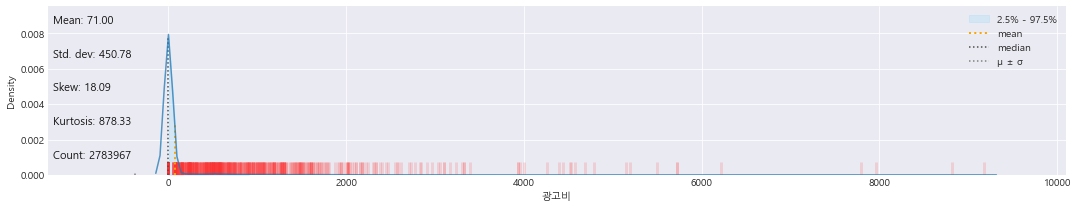

In [11]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import cm
path = 'c:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
plt.style.use('seaborn-darkgrid') 
rc('font', family=font_name)

import klib

klib.dist_plot(df_numeric['광고비'])

In [12]:
import numpy as np

def outlier_detection(df,column):
  q1 = np.percentile(df[column].values, 25)
  q3 = np.percentile(df[column].values, 75)
  iqr = q3 - q1
  w = iqr*1.5
  lowest = q1 - w
  highest = q3 + w
  
  outlier_idx = df[column][(df[column]<lowest) | (df[column]>highest)].index
  return outlier_idx

In [13]:
outlier_idx = outlier_detection(df=df, column='광고비')
print("iqr로 파악한 광고비 항목의 이상치 개수: %s개"%len(outlier_idx))
print("광고비가 1 이상인 행의 개수:%s개"%len(df[df['광고비']>0]))

iqr로 파악한 광고비 항목의 이상치 개수: 177464개
광고비가 1 이상인 행의 개수:177464개


<font color="red"><p>
#### - 광고비의 약 94%는 0으로 채워져 있음을 확인
#### - 대부분의 광고비가 0으로 채워져 있기 때문에 이상치 판단에 어려움이 있음

#### 3-2. 노출

In [14]:
df_numeric['노출'].value_counts(normalize=True)[:10]

1    0.40
2    0.18
3    0.10
4    0.06
5    0.04
6    0.03
7    0.02
8    0.02
9    0.01
10   0.01
Name: 노출, dtype: float64

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='노출', ylabel='Density'>

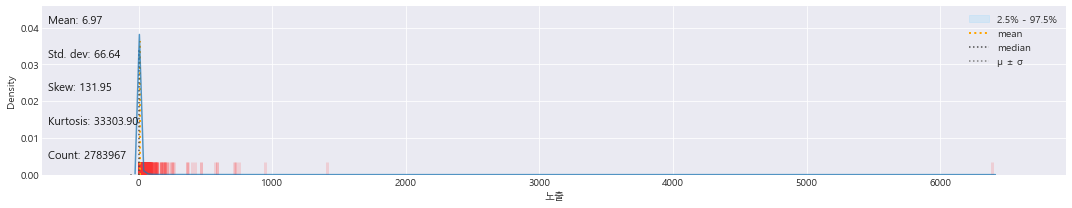

In [15]:
klib.dist_plot(df_numeric['노출'])

In [16]:
outlier_idx = outlier_detection(df=df, column='노출')
print("iqr로 파악한 노출 항목의 이상치 개수: %s개"%len(outlier_idx))

iqr로 파악한 노출 항목의 이상치 개수: 282730개


<font color="red"><p>
#### - 전체 데이터에서 약 40%는 노출이 1건만 있음을 확인

#### 3-3. 클릭

In [17]:
df_numeric['클릭'].value_counts(normalize=True)[:5]

0   0.94
1   0.05
2   0.01
3   0.00
4   0.00
Name: 클릭, dtype: float64

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='클릭', ylabel='Density'>

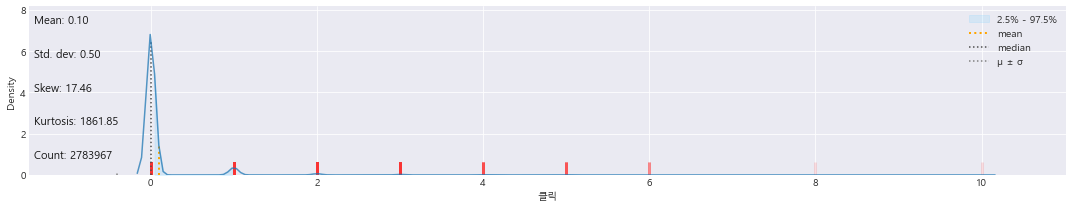

In [18]:
klib.dist_plot(df_numeric['클릭'])

In [19]:
outlier_idx = outlier_detection(df=df_numeric, column='클릭')
print("iqr로 파악한 클릭 항목의 이상치 개수: %s개"%len(outlier_idx))

iqr로 파악한 클릭 항목의 이상치 개수: 177464개


<font color="red"><p>
#### - 전체 데이터에서 약 94%는 클릭이 없음을 확인

#### 3-4. 매출

In [20]:
df_numeric['매출'].value_counts(normalize=True)[:5]

0       0.99
1       0.00
2       0.00
24800   0.00
79000   0.00
Name: 매출, dtype: float64

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='매출', ylabel='Density'>

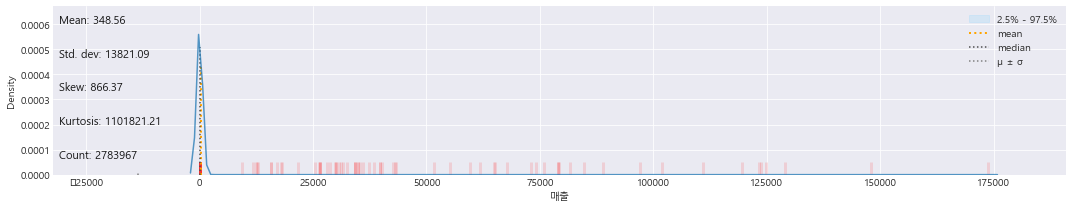

In [21]:
klib.dist_plot(df_numeric['매출'])

In [22]:
outlier_idx = outlier_detection(df=df_numeric, column='매출')
print("iqr로 파악한 매출 항목의 이상치 개수: %s개"%len(outlier_idx))
print("매출이 1 이상인 행의 개수:%s개"%len(df[df['매출']>0]))

iqr로 파악한 매출 항목의 이상치 개수: 18125개
매출이 1 이상인 행의 개수:18125개


<font color="red"><p>
#### - 전체 데이터에서 약 99%는 매출이 0으로 채워져 있음을 확인
#### - 대부분의 매출이 0으로 채워져 있기 때문에 이상치 판단에 어려움이 있음
#### - 수치형 데이터가 전체적으로 0으로 채워진 값이 대부분이어서 이상치 여부 판단 쉽지 않음을 확인

<font color="#808080"><p>
### 4. categorical data 

In [23]:
df_cat = df.select_dtypes(include=['object'])
df_cat.drop(columns='날짜',inplace=True)
df_cat

,매체,요일,시간대별,캠페인,광고그룹,키워드
0,PC,화,00시~01시,실외용품,Brand,불스원김서림방지
1,PC,화,08시~09시,실외용품,Brand,불스원와이퍼
2,PC,화,08시~09시,실외용품,Brand,불스원하이브리드와이퍼
3,PC,화,08시~09시,실외용품,Non-brand,글라스코팅제
4,PC,화,08시~09시,실외용품,Non-brand,셀프유리막코팅제
...,...,...,...,...,...,...
2783962,모바일,목,23시~00시,공기청정_방향제_필터,Non-brand,차량에어컨필터
2783963,모바일,목,23시~00시,공기청정_방향제_필터,Non-brand,차량용방향제
2783964,모바일,목,23시~00시,공기청정_방향제_필터,Non-brand,뿌리는살균소독제
2783965,모바일,목,23시~00시,공기청정_방향제_필터,Non-brand,뿌리는소독약


GridSpec(6, 6)

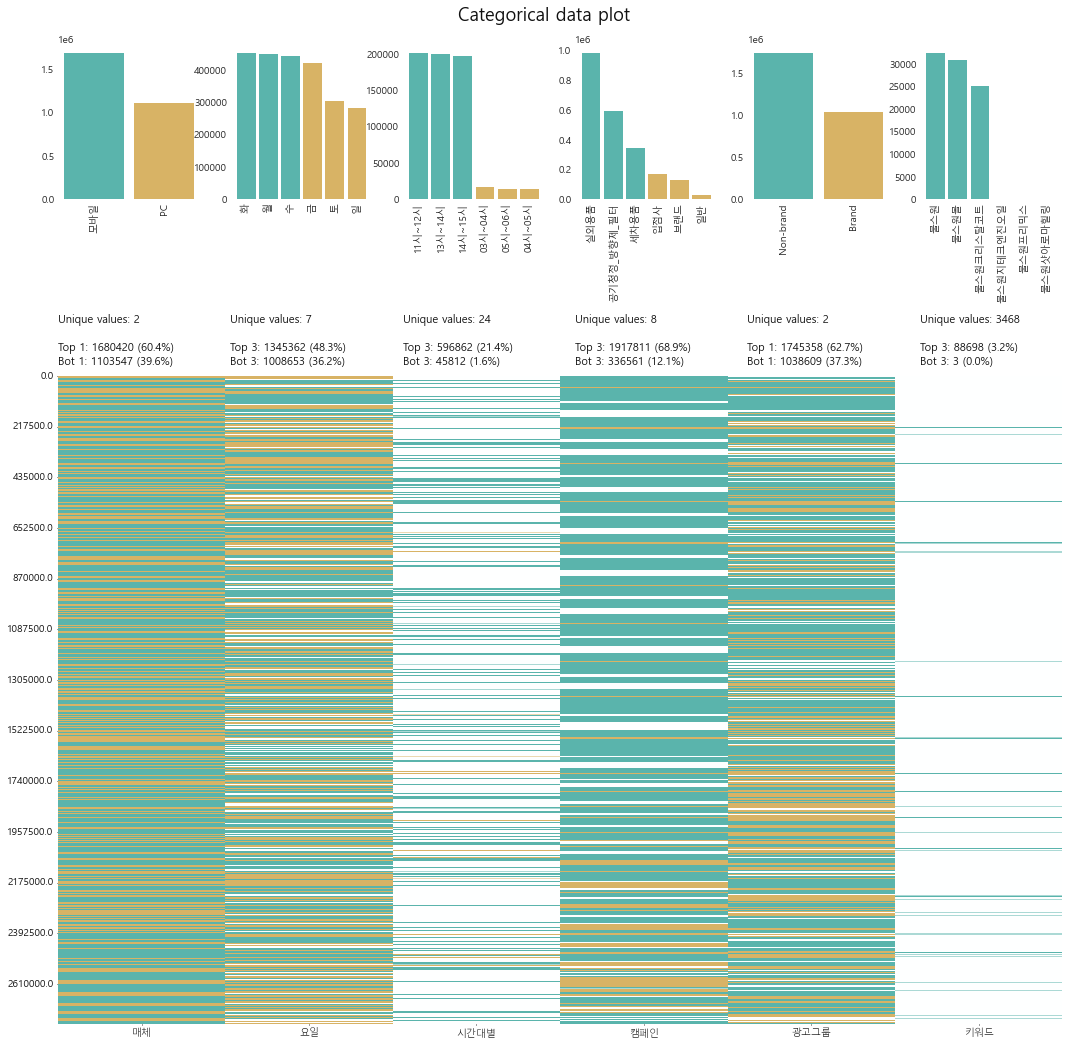

In [24]:
klib.cat_plot(df_cat)

<font color="#808080"><p>
### 5. data encoding

In [25]:
df_corr = df.copy()
df_corr['날짜'] = pd.to_datetime(df_corr['날짜'])
df_corr['요일'] = df_corr['날짜'].dt.dayofweek

In [26]:
cat_columns = ['매체','시간대별','캠페인','광고그룹','키워드']

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cat_columns = ['매체','시간대별','캠페인','광고그룹','키워드']
for i in cat_columns:
    df_corr[i] = le.fit_transform(df_cat[i])

In [28]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783967 entries, 0 to 2783966
Data columns (total 13 columns):
 #   Column  Dtype         
---  ------  -----         
 0   매체      int32         
 1   날짜      datetime64[ns]
 2   월       int64         
 3   요일      int64         
 4   시간대별    int32         
 5   캠페인     int32         
 6   광고그룹    int32         
 7   키워드     int32         
 8   광고비     int64         
 9   노출      int64         
 10  클릭      int64         
 11  매출      int64         
 12  평균노출순위  float64       
dtypes: datetime64[ns](1), float64(1), int32(5), int64(6)
memory usage: 223.0 MB


In [29]:
df_corr

,매체,날짜,월,요일,시간대별,캠페인,광고그룹,키워드,광고비,노출,클릭,매출,평균노출순위
0,0,2019-01-01,1,1,0,3,0,733,0,1,0,0,1.00
1,0,2019-01-01,1,1,8,3,0,1287,0,2,0,0,1.00
2,0,2019-01-01,1,1,8,3,0,1503,0,2,0,0,1.00
3,0,2019-01-01,1,1,8,3,1,156,0,14,0,0,10.00
4,0,2019-01-01,1,1,8,3,1,1899,0,15,0,0,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783962,1,2020-12-31,12,3,23,0,1,2734,0,4,0,0,3.00
2783963,1,2020-12-31,12,3,23,0,1,2818,0,6,0,0,4.00
2783964,1,2020-12-31,12,3,23,0,1,1762,0,2,0,0,4.00
2783965,1,2020-12-31,12,3,23,0,1,1768,0,1,0,0,1.00


<font color="#OOOOFF"><p>
## Data correlation

1. 전체 데이터의 상관관계 파악
2. 노출 / 클릭 / 매출의 연관성 비교
3. 월 / 요일 / 시간대에 따른 노출, 클릭,매출의 차이와 상관관계

<font color="#808080"><p>
### 1. 전체 데이터의 변수별 상관관계

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

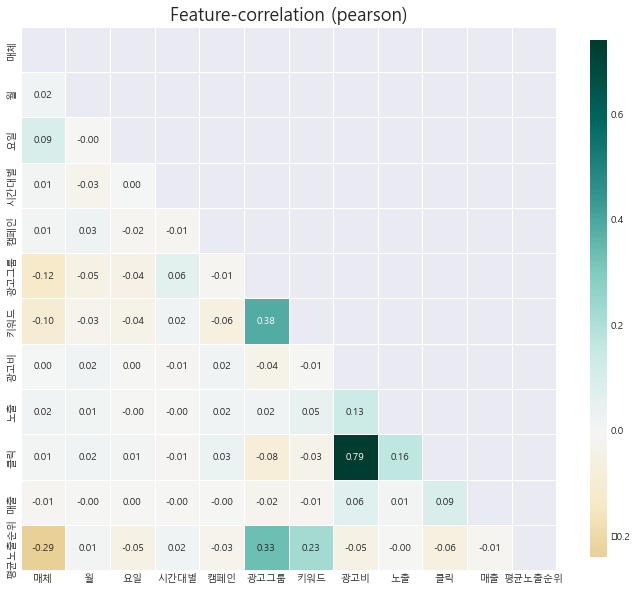

In [30]:
klib.corr_plot(df_corr)

<font color="red"><p>
- 1. [클릭, 광고비] = 0.79
- 2. [키워드, 광고그룹] = 0.37
- 3. [광고그룹, 평균노출순위] = 0.31
- 4. [매체, 평균노출순위] = -0.29
- 5. [키워드, 평균노출순위] = 0.23

<font color="#808080"><p>
### 2. 노출과 클릭, 매출의 상관계수 및 검정

#### 2-1. 노출과 클릭

In [31]:
import scipy.stats as stats

x = df_corr['노출'].values
y = df_corr['클릭'].values

a=stats.pearsonr(x,y)
b=stats.spearmanr(x,y)

print("노출과 클릭의 Pearson 상관계수: {}, p-value: {}".format(a[0],a[1]))
print("노출과 클릭의 Spearman 상관계수: {}, p-value: {}".format(b[0],b[1]))

노출과 클릭의 Pearson 상관계수: 0.16332551303836806, p-value: 0.0
노출과 클릭의 Spearman 상관계수: 0.2333640751492109, p-value: 0.0


#### 2.2 노출과 매출

In [32]:
x = df_corr['노출'].values
y = df_corr['매출'].values

a=stats.pearsonr(x,y)
b=stats.spearmanr(x,y)

print("노출과 매출의 Pearson 상관계수: {}, p-value: {}".format(a[0],a[1]))
print("노출과 매출의 Spearman 상관계수: {}, p-value: {}".format(b[0],b[1]))

노출과 매출의 Pearson 상관계수: 0.005885093621012732, p-value: 9.281083653825378e-23
노출과 매출의 Spearman 상관계수: 0.07882841848387655, p-value: 0.0


#### 2-3. 클릭과 매출

In [33]:
x = df_corr['클릭'].values
y = df_corr['매출'].values

a=stats.pearsonr(x,y)
b=stats.spearmanr(x,y)

print("클릭과 매출의 Pearson 상관계수: {}, p-value: {}".format(a[0],a[1]))
print("클릭과 매출의 Spearman 상관계수: {}, p-value: {}".format(b[0],b[1]))

클릭과 매출의 Pearson 상관계수: 0.09087910469259078, p-value: 0.0
클릭과 매출의 Spearman 상관계수: 0.2493675718258778, p-value: 0.0


<font color="red"><p>
#### - [클릭, 매출] > [노출, 클릭] > [노출, 매출] 순의 상관계수
#### - [클릭, 매출]과 [노출, 클릭]간에는 아주 약한 상관관계가 존재
#### - [노출, 매출]은 상관관계가 없음

<font color="#808080"><p>
### 3. 월 / 요일 / 시간대에 따른 노출, 클릭,매출의 차이와 상관관계

### 3-1. 요일

#### 3-1-1. 요일별 매출 차이 

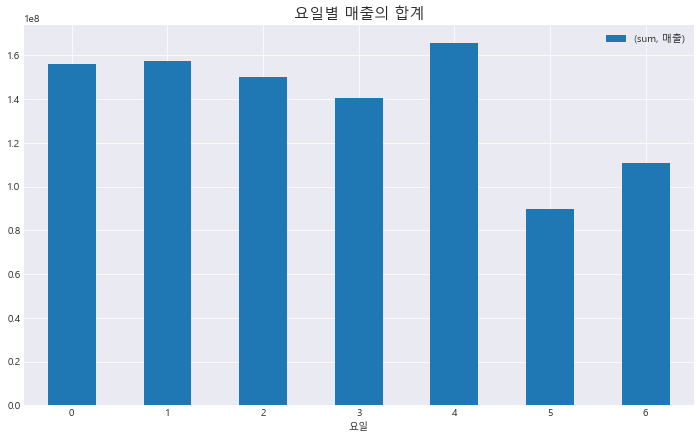

In [34]:
df_corr.pivot_table(index='요일', values=['매출'], aggfunc=[np.sum]).plot.bar(figsize=(12,7))
plt.legend(fontsize=10)
plt.xticks(rotation=0, fontsize=10)
plt.title("요일별 매출의 합계", fontsize=15)
plt.show()

In [35]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
from statsmodels.stats.multicomp import MultiComparison

model = ols('매출 ~ C(요일)', df_corr).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(요일),6.00,"2,381,643,161.88","396,940,526.98",2.08,0.05
Residual,"2,783,960.00","531,797,905,842,892.75","191,022,107.30",NaN,NaN


#### 3-1-2. 요일별 매출 차이 사후분석

In [36]:
hsd = pairwise_tukeyhsd(df_corr.매출, df_corr.요일, alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1.2945,0.9,-84.5458,87.1347,False
0,2,-9.1661,0.9,-95.3981,77.0659,False
0,3,-19.9949,0.9,-106.9318,66.942,False
0,4,45.0055,0.7062,-42.3349,132.3459,False
0,5,-50.8332,0.6793,-146.6032,44.9368,False
0,6,43.5961,0.8265,-54.1799,141.372,False
1,2,-10.4606,0.9,-96.5552,75.6341,False
1,3,-21.2893,0.9,-108.0901,65.5114,False
1,4,43.7111,0.7305,-43.4938,130.9159,False
1,5,-52.1276,0.6547,-147.774,43.5188,False


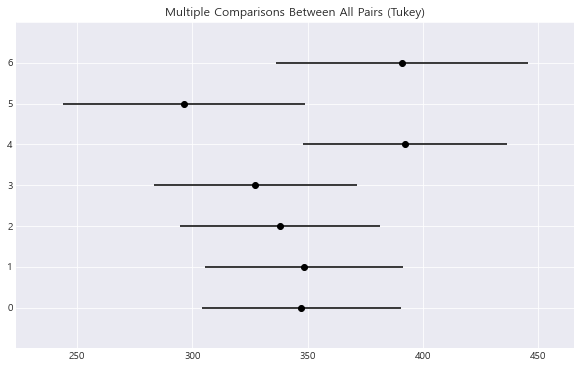

In [37]:
fig = hsd.plot_simultaneous()

<font color="red"><p>
#### - 금요일과 토요일의 매출 합계는 신뢰구간에 따라 매출의 차이가 존재할 수 있다고 볼 수 있다.
#### - 금요일과 토요일의 매출 차이를 제외한 나머지 집단들은 매출의 차이가 있다고 보기 어렵다.

#### 3-1-3. 요일별 노출과 클릭의 상관계수 

In [38]:
def day_corr(df, cat, column1, column2):
    day_list = []
    for i in df[cat].unique():
        day_i = df.loc[df[cat] == i][[column1, column2]].corr()
        day_i[cat] = str(i)
        day_list.append(day_i)

    day_corr = pd.concat(day_list)
    day_corr = pd.DataFrame(day_corr);day_corr.set_index(cat, inplace=True)
    day_corr.drop(columns = column1, inplace=True);day_corr.columns = ['corr']
    day = day_corr.sort_values(by='corr', ascending=False)[7:]
    return day

In [39]:
day_corr(df,'요일','노출','클릭')

,corr
요일,
일,0.23
토,0.20
금,0.18
수,0.17
월,0.17
목,0.17
화,0.12


<font color="red"><p>
#### - 요일별 노출과 클릭과의 편차가 존재한다.

#### 3-1-4. 요일별 노출과 매출의 상관계수

In [40]:
day_corr(df,'요일','노출','매출')

,corr
요일,
일,0.02
월,0.02
토,0.02
수,0.01
목,0.01
화,0.01
금,0.00


<font color="red"><p>
#### - 노출과 매출은 요일에 관계없이 상관관계가 없다.

#### 3-1-5. 요일별 클릭과 매출의 상관계수

In [41]:
day_corr(df,'요일','클릭','매출')

,corr
요일,
일,0.21
월,0.21
수,0.17
토,0.16
화,0.15
목,0.12
금,0.04


<font color="red"><p>
#### - 클릭과 매출은 요일에 따라 상관계수의 편차가 존재한다.

### 3-2. 시간대

#### 3-2-1. 시간대별 매출 차이

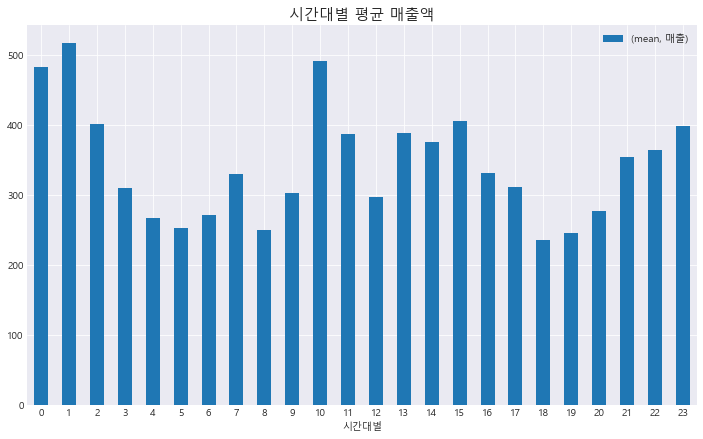

In [42]:
df_corr.pivot_table(index='시간대별', values=['매출'], aggfunc=[np.mean]).plot.bar(figsize=(12,7))
plt.legend(fontsize=10)
plt.xticks(rotation=0, fontsize=10)
plt.title("시간대별 평균 매출액", fontsize=15)
plt.show()

In [43]:
model = ols('매출 ~ C(시간대별)', df_corr).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(시간대별),23.00,"14,306,336,661.69","622,014,637.46",3.26,0.00
Residual,"2,783,943.00","531,785,981,148,979.94","191,018,990.38",NaN,NaN


#### 3-2-2. 시간대별 매출 차이 사후 분석

In [44]:
hsd = pairwise_tukeyhsd(df_corr.매출, df_corr.시간대별, alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,35.0434,0.9,-309.361,379.4479,False
0,2,-80.1283,0.9,-479.5183,319.2617,False
0,3,-172.2719,0.9,-607.7833,263.2394,False
0,4,-215.7595,0.9,-683.078,251.559,False
0,5,-229.0619,0.9,-690.6441,232.5204,False
0,6,-210.9862,0.9,-596.7362,174.7639,False
0,7,-151.6795,0.9,-480.4224,177.0634,False
0,8,-232.5231,0.1358,-488.1166,23.0703,False
0,9,-179.2017,0.481,-416.3903,57.987,False
0,10,8.775,0.9,-222.4762,240.0262,False


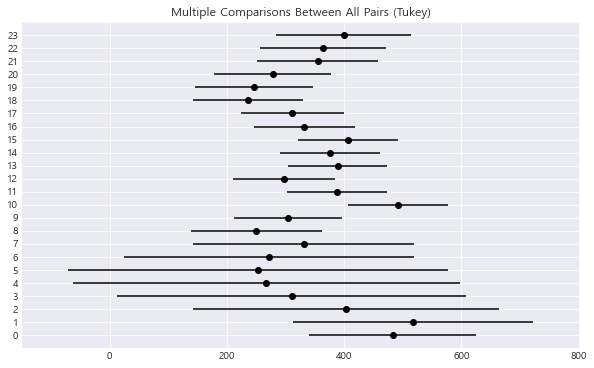

In [45]:
fig = hsd.plot_simultaneous()

<font color="red"><p>
#### - (0시-1시)와 (18시-19시)두 집단의 매출 차이가 있다.
#### - (10시-11시) 시간대의 매출은 (8시-9시), (9시-10시), (12시-13시), (17시-18시), (18시-19시), (19시-20시), (20시-21시) 시간대의 매출과의 차이가 있다.
#### - 특정 시간대의 집합은 서로 차이가 있음을 확인하였다.

#### 3-2-3. 시간대별 노출과 클릭의 상관계수 

In [46]:
def time_corr(df,cat,column1,column2):
    time_list = []
    for i in range(df[cat].nunique()):
        time_i = df.loc[df[cat] == i][[column1,column2]].corr()
        time_i[cat] = str(i)+'시'+'~'+str(i+1)+'시'
        time_list.append(time_i)
    time_corr = pd.concat(time_list)
    time_corr = pd.DataFrame(time_corr);time_corr.set_index(cat, inplace=True)
    time_corr.drop(columns = column2, inplace=True);time_corr.columns = ['corr']
    time = time_corr.sort_values(by='corr', ascending=False).iloc[24:,:1]
    return time

In [47]:
time_corr(df_corr,'시간대별', '노출','클릭')

,corr
시간대별,
22시~23시,0.31
23시~24시,0.28
7시~8시,0.23
10시~11시,0.23
0시~1시,0.22
1시~2시,0.20
16시~17시,0.20
11시~12시,0.20
12시~13시,0.19


<font color="red"><p>
#### - 시간대에 따라서 노출과 클릭간의 상관관계의 편차가 있다.

#### 3-2-4. 시간대별 노출과 매출의 상관계수

In [48]:
time_corr(df_corr,'시간대별','노출','매출')

,corr
시간대별,
4시~5시,0.04
22시~23시,0.04
2시~3시,0.03
1시~2시,0.03
6시~7시,0.03
23시~24시,0.03
7시~8시,0.02
18시~19시,0.02
5시~6시,0.02


<font color="red"><p>
#### - 노출과 매출은 시간대에 따른 상관계수의 차이가 없고 앞선 결과와 같이 노출과 매출간의 관계가 있다고 보기 어렵다.

#### 3-2-5. 시간대별 클릭과 매출의 상관계수

In [49]:
time_corr(df_corr,'시간대별','클릭','매출')

,corr
시간대별,
8시~9시,0.24
12시~13시,0.20
13시~14시,0.20
16시~17시,0.20
2시~3시,0.20
20시~21시,0.20
9시~10시,0.19
4시~5시,0.19
18시~19시,0.19


<font color="red"><p>
#### - 시간대별로 노출과 매출의 상관계수의 편차가 존재한다.

### 3-3. 월

#### 3-3-1. 월별 매출 차이 

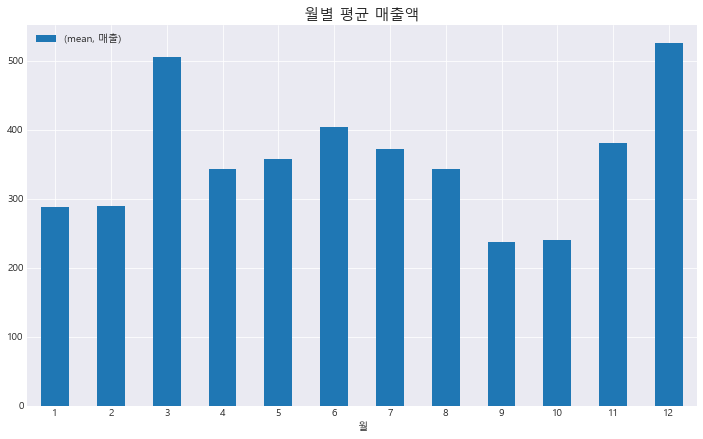

In [50]:
df_corr.pivot_table(index='월', values=['매출'], aggfunc=[np.mean]).plot.bar(figsize=(12,7))
plt.legend(fontsize=10)
plt.xticks(rotation=0, fontsize=10)
plt.title("월별 평균 매출액", fontsize=15)
plt.show()

In [51]:
model = ols('매출 ~ C(월)', df_corr).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(월),11.00,"18,945,814,876.90","1,722,346,806.99",9.02,0.00
Residual,"2,783,955.00","531,781,341,670,683.56","191,016,500.51",NaN,NaN


#### 3-3-2. 월별 매출 사후분석

In [52]:
hsd = pairwise_tukeyhsd(df_corr.매출, df_corr.월, alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,1.6068,0.9,-135.203,138.4165,False
1,3,218.0248,0.001,84.2205,351.8292,True
1,4,55.5083,0.9,-73.7494,184.7661,False
1,5,69.8526,0.7971,-57.3356,197.0408,False
1,6,116.4502,0.1567,-16.7499,249.6503,False
1,7,83.971,0.6023,-46.4104,214.3525,False
1,8,55.2055,0.9,-78.2015,188.6126,False
1,9,-50.8545,0.9,-181.1834,79.4743,False
1,10,-48.1431,0.9,-177.7871,81.501,False
1,11,92.9642,0.6349,-55.0299,240.9583,False


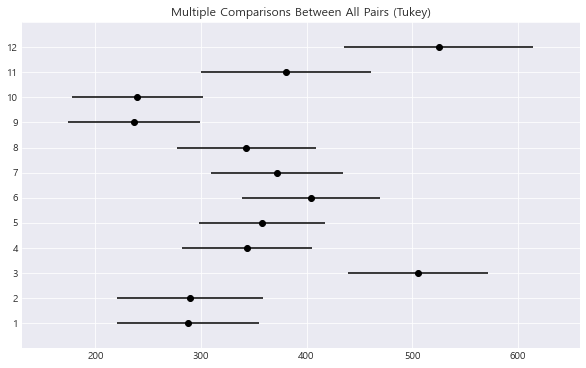

In [53]:
fig = hsd.plot_simultaneous()

<font color="red"><p>
#### - 3월과 12월의 매출이 상대적으로 다른 월에 비해 높아 대부분의 월과 매출의 차이가 있음

#### 3-3-3. 월별 노출과 클릭의 상관계수

In [54]:
def month_corr(df, cat, column1, column2):
    month_list = []
    for i in df[cat].unique():
        month_i = df.loc[df[cat] == i][[column1, column2]].corr()
        month_i[cat] = str(i)
        month_list.append(month_i)

    month_corr = pd.concat(month_list)
    month_corr = pd.DataFrame(month_corr);month_corr.set_index(cat, inplace=True)
    month_corr.drop(columns = column1, inplace=True);month_corr.columns = ['corr']
    month = month_corr.sort_values(by='corr', ascending=False)[12:]
    return month

In [55]:
month_corr(df,'월','노출','클릭')

,corr
월,
5,0.41
4,0.38
2,0.36
12,0.35
3,0.34
10,0.27
6,0.26
1,0.24
9,0.20


<font color="red"><p>
#### - 월별로 노출과 클릭의 상관계수 편차가 크게 나타난다.

#### 3-3-4. 월별 노출과 매출의 상관계수

In [56]:
month_corr(df,'월','노출','매출')

,corr
월,
12,0.07
5,0.05
2,0.05
4,0.03
6,0.03
1,0.03
9,0.02
8,0.02
7,0.02


<font color="red"><p>
#### - 월별에 관계없이 노출과 매출의 상관관계는 거의 없다.

#### 3-3-5. 월별 클릭과 매출의 상관계수

In [57]:
month_corr(df,'월','클릭','매출')

,corr
월,
9,0.28
10,0.26
11,0.26
12,0.21
1,0.18
7,0.18
8,0.17
2,0.15
5,0.15


<font color="red"><p>
#### - 월별에 따라 클릭과 매출의 상관계수의 편차가 존재한다.

<font color="#0000FF"><p>
## 4. Data comparison by advertising group 

<font color="#808080"><p>
### 4-1. Non-Brand 

In [58]:
non_brand = df[df['광고그룹'] == 'Non-brand']
non_brand

,매체,날짜,월,요일,시간대별,캠페인,광고그룹,키워드,광고비,노출,클릭,매출,평균노출순위
3,PC,2019-01-01,1,화,08시~09시,실외용품,Non-brand,글라스코팅제,0,14,0,0,10.00
4,PC,2019-01-01,1,화,08시~09시,실외용품,Non-brand,셀프유리막코팅제,0,15,0,0,9.00
5,PC,2019-01-01,1,화,08시~09시,실외용품,Non-brand,유리막코팅제,0,1,0,0,5.00
6,PC,2019-01-01,1,화,08시~09시,실외용품,Non-brand,유리발수코팅제,0,12,0,0,17.00
7,PC,2019-01-01,1,화,08시~09시,실외용품,Non-brand,자동차워셔액,0,1,0,0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783962,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,차량에어컨필터,0,4,0,0,3.00
2783963,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,차량용방향제,0,6,0,0,4.00
2783964,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,뿌리는살균소독제,0,2,0,0,4.00
2783965,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Non-brand,뿌리는소독약,0,1,0,0,1.00


In [59]:
non_brand[non_brand['키워드'].str.contains('불스원')]

,매체,날짜,월,요일,시간대별,캠페인,광고그룹,키워드,광고비,노출,클릭,매출,평균노출순위


In [60]:
print("Non-Brand 키워드 수: %s개"%non_brand['키워드'].nunique())
print("Non-Brand 키워드 수 비중: {}%".format(round((non_brand.키워드.nunique()/df.키워드.nunique())*100,2)))
print("Non-Brand 키워드의 광고비 비중: {}%".format(round(((non_brand.광고비.sum() / df.광고비.sum())*100),2)))
print("Non-Brand 키워드의 노출 비중: {}%".format(round(((non_brand.노출.sum() / df.노출.sum())*100),2)))
print("Non-Brand 키워드의 클릭 비중: {}%".format(round(((non_brand.클릭.sum() / df.클릭.sum())*100),2)))
print("Non-Brand 키워드의 매출 비중: {}%".format(round(((non_brand.매출.sum() / df.매출.sum())*100),2)))
print("Non-Brand 키워드의 평균노출순위: %s위"%(round(non_brand['평균노출순위'].mean(),2)))

Non-Brand 키워드 수: 2546개
Non-Brand 키워드 수 비중: 73.41%
Non-Brand 키워드의 광고비 비중: 51.52%
Non-Brand 키워드의 노출 비중: 73.68%
Non-Brand 키워드의 클릭 비중: 42.44%
Non-Brand 키워드의 매출 비중: 23.73%
Non-Brand 키워드의 평균노출순위: 2.9위


<font color="#808080"><p>
### 4-2. Brand 

In [61]:
brand = df[df['광고그룹']=='Brand']
brand

,매체,날짜,월,요일,시간대별,캠페인,광고그룹,키워드,광고비,노출,클릭,매출,평균노출순위
0,PC,2019-01-01,1,화,00시~01시,실외용품,Brand,불스원김서림방지,0,1,0,0,1.00
1,PC,2019-01-01,1,화,08시~09시,실외용품,Brand,불스원와이퍼,0,2,0,0,1.00
2,PC,2019-01-01,1,화,08시~09시,실외용품,Brand,불스원하이브리드와이퍼,0,2,0,0,1.00
14,PC,2019-01-01,1,화,09시~10시,실외용품,Brand,불스원워셔액,0,1,0,0,1.00
39,PC,2019-01-01,1,화,10시~11시,실외용품,Brand,불스원이지그립,0,1,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783954,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Brand,불스원공기청정기,0,1,0,0,1.00
2783955,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Brand,불스원방향제,0,4,0,0,1.00
2783956,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Brand,불스원샷방향제,0,1,0,0,1.00
2783957,모바일,2020-12-31,12,목,23시~00시,공기청정_방향제_필터,Brand,불스원에어컨필터,0,3,0,0,1.00


In [62]:
print("Brand 키워드 수: %s개"%brand['키워드'].nunique())
print("Brand 키워드 수 비중: {}%".format(round((brand.키워드.nunique()/df.키워드.nunique())*100,2)))
print("Brand 키워드의 광고비 비중: {}%".format(round(((brand.광고비.sum() / df.광고비.sum())*100),2)))
print("Brand 키워드의 노출 비중: {}%".format(round(((brand.노출.sum() / df.노출.sum())*100),2)))
print("Brand 키워드의 클릭 비중: {}%".format(round(((brand.클릭.sum() / df.클릭.sum())*100),2)))
print("Brand 키워드의 매출 비중: {}%".format(round(((brand.매출.sum() / df.매출.sum())*100),2)))
print("Brand 키워드의 평균노출순위: %s위"%(round(brand['평균노출순위'].mean(),2)))

Brand 키워드 수: 922개
Brand 키워드 수 비중: 26.59%
Brand 키워드의 광고비 비중: 48.48%
Brand 키워드의 노출 비중: 26.32%
Brand 키워드의 클릭 비중: 57.56%
Brand 키워드의 매출 비중: 76.27%
Brand 키워드의 평균노출순위: 1.09위


<font color="red"><p>
#### - Brand 키워드와 Non-Brand 키워드의 운영 광고비는 Non-brand 키워드가 조금 더 차지하고 있지만 전체 매출의 76.27%가 Brand 키워드에서 발생한다.
#### - 향후 매출 증가를 위해 좀 더 각 키워드 별 세밀한 분석이 필요하다.
#### - 비용대비 키워드 성과 파악을 통해 효율적인 키워드 운영이 필요할 것으로 보인다.

<font color="#0000FF"><p>
## Keyword performance analysis

<font color="#808080"><p>
### 키워드 군집 분석

- ROAS : 광고비에 대한 매출 비율 
- ROI : 투자 이익율
- CPC : 클릭 당 비용
- CTR : 클릭률
- Cluster: 매출 x ROI (키워드의 매출과 순 이익률을 고려한 지표)

#### 키워드 데이터 생성

In [63]:
count = df.groupby('키워드')['매출'].count().values
keyword = df.groupby('키워드').agg({'광고비':'sum' , '노출':'sum' , '클릭':'sum' , '매출':'sum'}).reset_index()
keyword['건수'] = count
keyword['ROAS'] = ((keyword['매출'] / keyword['광고비'])*100)
keyword['ROI'] = (((keyword['매출'] - keyword['광고비']) / (keyword['광고비'])) *100)
keyword['CPC'] = (keyword['광고비'] / keyword['클릭'])
keyword['CTR'] = ((keyword['클릭'] / keyword['노출'])*100)
keyword['CLUSTER'] = ((keyword['매출'] * (keyword['ROI']/100)))
keyword['CLUSTER'] = keyword['CLUSTER'] / keyword['CLUSTER'].mean()
keyword.fillna(0, inplace=True)
keyword

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER
0,2스텝컴파운드,1595,1375,1,0,904,0.00,-100.00,"1,595.00",0.07,-0.00
1,3스텝컴파운드,6567,2733,6,0,1671,0.00,-100.00,"1,094.50",0.22,-0.00
2,APROVIEWSO,0,39,0,0,27,0.00,0.00,0.00,0.00,0.00
3,BMW광각미러,66363,2322,50,149002,1204,224.53,124.53,"1,327.26",2.15,0.02
4,BMW에어컨필터,23364,4401,26,0,2111,0.00,-100.00,898.62,0.59,-0.00
...,...,...,...,...,...,...,...,...,...,...,...
3463,히터냄새제거,0,8,0,0,8,0.00,0.00,0.00,0.00,0.00
3464,히터냄세제거,0,6,0,0,6,0.00,0.00,0.00,0.00,0.00
3465,히터방향제,0,19,0,0,19,0.00,0.00,0.00,0.00,0.00
3466,히터탈취,0,29,0,0,23,0.00,0.00,0.00,0.00,0.00


#### 키워드 데이터 표준화

<font color="red"><p>
#### - 키워드데이터 변수 값들의 범위 차이가 너무 커 표준화과정 진행

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = keyword.copy()
data = data[['ROAS','CTR','ROI','CLUSTER']]
columns = data.columns

scaled_d = scaler.fit_transform(data)
scaled_d = pd.DataFrame(scaled_d)
scaled_d.columns = columns
scaled_d

,ROAS,CTR,ROI,CLUSTER
0,-0.06,-0.30,-0.06,-0.03
1,-0.06,-0.28,-0.06,-0.03
2,-0.06,-0.31,-0.06,-0.03
3,-0.04,-0.00,-0.04,-0.03
4,-0.06,-0.22,-0.06,-0.03
...,...,...,...,...
3463,-0.06,-0.31,-0.06,-0.03
3464,-0.06,-0.31,-0.06,-0.03
3465,-0.06,-0.31,-0.06,-0.03
3466,-0.06,-0.31,-0.06,-0.03


In [65]:
scaled_d.describe()

,ROAS,CTR,ROI,CLUSTER
count,"3,468.00","3,468.00","3,468.00","3,468.00"
mean,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-0.06,-0.31,-0.06,-0.03
25%,-0.06,-0.31,-0.06,-0.03
50%,-0.06,-0.26,-0.06,-0.03
75%,-0.06,-0.07,-0.06,-0.03
max,53.24,14.01,53.25,55.58


#### 키워드 데이터 군집화

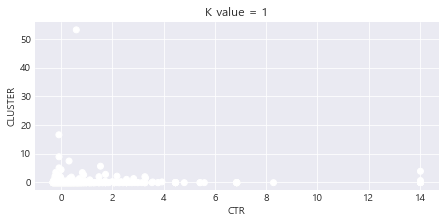

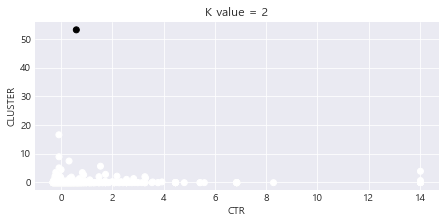

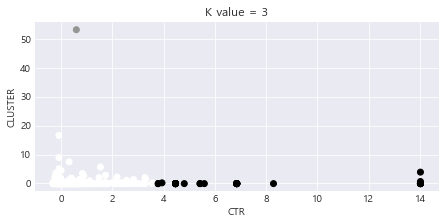

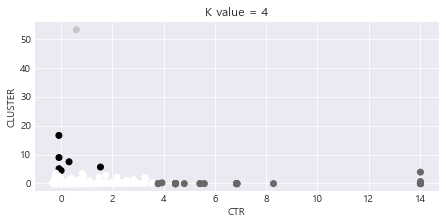

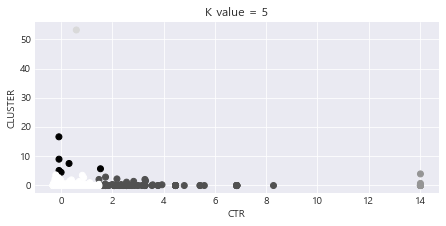

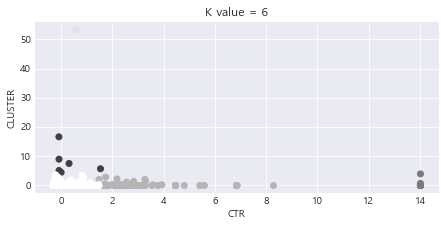

In [66]:
from sklearn.cluster import KMeans

for i in range(1, 7):
   estimator = KMeans(n_clusters = i)
   ids = estimator.fit_predict(scaled_d)
   plt.figure(figsize=(12,8))
   plt.subplot(3, 2, i)
   plt.tight_layout()
   plt.title("K value = {}".format(i))
   plt.xlabel('CTR')
   plt.ylabel('CLUSTER')
   plt.scatter(scaled_d['CTR'], scaled_d['ROAS'], c=ids)  
plt.show()

In [67]:
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(scaled_d)
keyword['LABEL'] = clusters.labels_
keyword['LABEL'].value_counts()

0    3353
4      99
2       9
3       6
1       1
Name: LABEL, dtype: int64

#### 군집결과 시각화

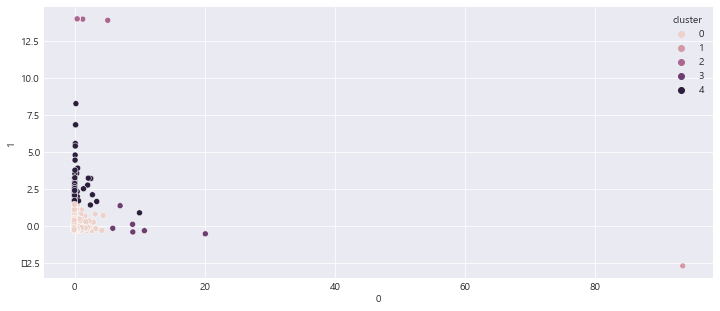

In [68]:
from sklearn.decomposition import PCA
import seaborn as sns

X = scaled_d.copy()
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = keyword['LABEL']

axs = plt.subplots(figsize=(12,5))
axs = sns.scatterplot(0,1, hue='cluster', data=pca_df)

In [69]:
keyword.groupby('LABEL').mean()

,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER
LABEL,,,,,,,,,,
0,"55,354.32","5,712.70",71.36,"217,991.58",819.21,296.89,237.22,343.24,1.21,0.13
1,385.00,79.00,5.00,"2,277,701.00",68.00,"591,610.65","591,510.65",77.00,6.33,"1,114.37"
2,85.56,1.11,1.11,"5,160.00",1.22,"5,803.75","5,703.75",77.00,100.00,0.15
3,938.67,145.00,3.17,"554,626.50",102.17,"90,100.43","90,000.43",190.46,4.04,29.20
4,"121,694.11","2,384.87",312.01,"2,361,679.66",368.18,"1,783.83","1,683.83",181.43,25.08,3.86


<font color="red"><p>
#### - o번 그룹으로 전체 키워드의 약 97% 배정
#### - 1번 그룹에는 단 1개의 키워드가 배정되었는데, 해당 키워드의 이익지표가 전체 데이터에 비해 너무 높아 배정(outlier)
#### - 2번 그룹에는 9개의 키워드 배정, 특이 사항으로는 해당 키워드의 클릭률이 모두 100%
#### - 4번 그룹에는 99개 키워드 배정, 2번 그룹을 제외한 가장 높은 평균 클릭률과 매출

### 키워드 그룹 재조정

In [70]:
key_0 = keyword[keyword['LABEL'] == 0]
key_1 = keyword[keyword['LABEL'] == 1]
key_2 = keyword[keyword['LABEL'] == 2]
key_3 = keyword[keyword['LABEL'] == 3]
key_4 = keyword[keyword['LABEL'] == 4]

### 0번 그룹 -> 저효율 키워드

In [71]:
key_0

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
0,2스텝컴파운드,1595,1375,1,0,904,0.00,-100.00,"1,595.00",0.07,-0.00,0
1,3스텝컴파운드,6567,2733,6,0,1671,0.00,-100.00,"1,094.50",0.22,-0.00,0
2,APROVIEWSO,0,39,0,0,27,0.00,0.00,0.00,0.00,0.00,0
3,BMW광각미러,66363,2322,50,149002,1204,224.53,124.53,"1,327.26",2.15,0.02,0
4,BMW에어컨필터,23364,4401,26,0,2111,0.00,-100.00,898.62,0.59,-0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3463,히터냄새제거,0,8,0,0,8,0.00,0.00,0.00,0.00,0.00,0
3464,히터냄세제거,0,6,0,0,6,0.00,0.00,0.00,0.00,0.00,0
3465,히터방향제,0,19,0,0,19,0.00,0.00,0.00,0.00,0.00,0
3466,히터탈취,0,29,0,0,23,0.00,0.00,0.00,0.00,0.00,0


In [72]:
key_0['ROI'].value_counts(normalize=True)

-100.00   0.41
0.00      0.40
135.39    0.00
578.75    0.00
-80.04    0.00
          ... 
360.58    0.00
418.45    0.00
119.71    0.00
180.27    0.00
11.72     0.00
Name: ROI, Length: 631, dtype: float64

<font color="red"><p>
#### - 0번 그룹 키워드의 80%이상이 투자한 비용만큼도 벌어들이지 못했다.

#### 0번 그룹에 배정된 고효율 키워드 재배정 

In [73]:
print("전체 키워드의 평균 거래 건수: %s건"%int(keyword['건수'].mean()))
print("전체 키워드의 평균 CLUSTER: %s"%(keyword['CLUSTER'].mean()))
print("전체 키워드의 평균 CTR: %s"%(keyword['CTR'].mean()))
print("전체 키워드의 평균 매출: %s"%int(keyword['매출'].mean()))

전체 키워드의 평균 거래 건수: 802건
전체 키워드의 평균 CLUSTER: 0.610149942329873
전체 키워드의 평균 CTR: 2.1549805809441938
전체 키워드의 평균 매출: 279810


In [74]:
key_0.loc[(key_0['매출'] > 0) & (key_0['건수'] > keyword['건수'].mean()) & (key_0['CLUSTER'] > (keyword['CLUSTER'].mean())*2) & (key_0['CTR'] > keyword['CTR'].mean()), 'LABEL'] = 1
new_key_1 =key_0[key_0['LABEL'] == 1]
key_0 = key_0[key_0['LABEL'] == 0];key_0

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
0,2스텝컴파운드,1595,1375,1,0,904,0.00,-100.00,"1,595.00",0.07,-0.00,0
1,3스텝컴파운드,6567,2733,6,0,1671,0.00,-100.00,"1,094.50",0.22,-0.00,0
2,APROVIEWSO,0,39,0,0,27,0.00,0.00,0.00,0.00,0.00,0
3,BMW광각미러,66363,2322,50,149002,1204,224.53,124.53,"1,327.26",2.15,0.02,0
4,BMW에어컨필터,23364,4401,26,0,2111,0.00,-100.00,898.62,0.59,-0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3463,히터냄새제거,0,8,0,0,8,0.00,0.00,0.00,0.00,0.00,0
3464,히터냄세제거,0,6,0,0,6,0.00,0.00,0.00,0.00,0.00,0
3465,히터방향제,0,19,0,0,19,0.00,0.00,0.00,0.00,0.00,0
3466,히터탈취,0,29,0,0,23,0.00,0.00,0.00,0.00,0.00,0


<font color="red"><p>
#### - 0번 그룹으로 배정된 키워드 중 평균보다 매출, 클릭률, 거래 건수, 평균 순이익의 2배보다 큰 키워드는 3번 그룹으로 재배정

In [75]:
key_0.loc[key_0['매출'] > 0].sort_values(by='CLUSTER', ascending=False)

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
1152,불스원세차세트,12342,1460,20,1713713,736,"13,885.21","13,785.21",617.10,1.37,19.54,0
1285,불스원와이드밀러,913,138,11,356002,119,"38,992.55","38,892.55",83.00,7.97,11.45,0
839,불스원먼지털이개,8536,1460,14,896314,760,"10,500.40","10,400.40",609.71,0.96,7.71,0
161,김서림방지,27995,14574,31,1451750,5408,"5,185.75","5,085.75",903.06,0.21,6.11,0
1012,불스원샷블랙휘발유,814,201,3,245002,118,"30,098.53","29,998.53",271.33,1.49,6.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3305,트렁크정리함,1044439,410500,1219,374200,1903,35.83,-64.17,856.80,0.30,-0.02,0
2884,차량용청소기,1428548,181566,1494,1111850,7625,77.83,-22.17,956.19,0.82,-0.02,0
2768,차량용공기청정기,2450734,873705,1409,1158719,4481,47.28,-52.72,"1,739.34",0.16,-0.05,0
2818,차량용방향제,3048188,397656,1562,882897,5965,28.96,-71.04,"1,951.46",0.39,-0.05,0


In [76]:
key_0.loc[key_0['CLUSTER'] > keyword['CLUSTER'].mean(), 'LABEL'] = 2 
new_key_2 = key_0[key_0['LABEL'] == 2]
key_0 = key_0.loc[key_0['LABEL'] == 0]
print("관심 키워드 그룹으로 재조정 될 키워드의 개수: %s개"% len(new_key_2))

관심 키워드 그룹으로 재조정 될 키워드의 개수: 54개


<font color="red"><p>
#### - 0번 그룹으로 배정된 키워드 중 평균보다 이익률이 높은 키워드는 일반 키워드 그룹 2번으로 재배정

In [77]:
key_0.describe()

,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
count,"3,278.00","3,278.00","3,278.00","3,278.00","3,278.00","3,278.00","3,278.00","3,278.00","3,278.00","3,278.00","3,278.00"
mean,"23,865.74","4,408.71",28.57,"39,755.91",687.31,174.73,115.98,337.05,1.17,0.01,0.00
std,"218,456.54","35,347.73",199.78,"295,844.50","1,607.59","1,130.96","1,125.64",462.78,2.06,0.06,0.00
min,0.00,1.00,0.00,0.00,1.00,0.00,-100.00,0.00,0.00,-0.08,0.00
25%,0.00,17.00,0.00,0.00,13.00,0.00,-100.00,0.00,0.00,0.00,0.00
50%,220.00,134.00,1.00,0.00,91.00,0.00,0.00,101.93,0.30,0.00,0.00
75%,"4,408.25","1,076.75",8.00,0.00,543.75,0.00,0.00,565.59,1.38,-0.00,0.00
max,"9,053,605.00","1,416,645.00","8,294.00","11,476,233.00","16,887.00","30,129.87","30,029.87","4,750.78",12.90,0.61,0.00


<font color="red"><p>
#### - 키워드 그룹 중 가장 낮은 평균 클릭률
#### - 가장 높은 평균 클릭당 비용
#### - 1번 그룹의 키워드를 저효율 키워드로 분류

#### 1번 그룹

In [78]:
key_1

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
886,불스원배게,385,79,5,2277701,68,"591,610.65","591,510.65",77.00,6.33,"1,114.37",1


In [79]:
keyword['매출'].max()

227426539

In [80]:
key_1['LABEL'] = 3
key_3 = pd.concat([key_1,key_3])

<font color="red"><p>
#### - 1번 그룹의 키워드는 전체 키워드 매출 중 가장 높은 매출을 달성한 키워드로 따로 분류되었고 고효율 키워드로 그룹 3으로 배정

### 2번 그룹 -> 일반 키워드

In [81]:
key_2

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
188,누진다초점사이드미러,77,1,1,0,1,0.00,-100.00,77.00,100.00,-0.00,2
597,불수원샷물왁스,154,2,2,12440,3,"8,077.92","7,977.92",77.00,100.00,0.08,2
1572,블스원70000가격,77,1,1,0,1,0.00,-100.00,77.00,100.00,-0.00,2
1592,블스원레스테렐,77,1,1,0,1,0.00,-100.00,77.00,100.00,-0.00,2
1608,블스원방가드,77,1,1,0,1,0.00,-100.00,77.00,100.00,-0.00,2
1717,블스원캐어잼,77,1,1,0,1,0.00,-100.00,77.00,100.00,-0.00,2
2605,제트비차량핸들커버,77,1,1,0,1,0.00,-100.00,77.00,100.00,-0.00,2
3224,킨톤휴대폰거치대,77,1,1,0,1,0.00,-100.00,77.00,100.00,-0.00,2
3398,필굿아로마컵,77,1,1,34000,1,"44,155.84","44,055.84",77.00,100.00,1.24,2


In [82]:
key_2.loc[key_2['CLUSTER'] > keyword['CLUSTER'].mean(), 'LABEL'] = 2

In [83]:
key_2['LABEL'] = 0
key_2.loc[key_2['CLUSTER'] > keyword['CLUSTER'].mean(), 'LABEL'] = 2
new_key_3 = key_2[key_2['LABEL'] == 0]
key_2 = key_2[key_2['LABEL'] ==2 ]
key_2 = pd.concat([key_2, new_key_2])
key_0 = pd.concat([key_0,new_key_3])

<font color="red"><p>
#### - 키워드 군집화 당시 클릭률을 지표로 사용했었기 때문에 2번 그룹에는 클릭률이 100%인 키워드들만 배정
#### - 9개의 키워드 중 7개의 키워드는 모두 노출이 1번 발생했고 클릭이 1번 발생, 매출은 발생하지 않았다. 
#### - 매출이 발생한 2개의 키워드도 낮은 광고비 때문에 높은 ROI를 보여 고효율 키워드처럼 보일 수 있지만 거래 건수도 매우 작고 매출의 규모도 작기 때문에 고효율 키워드로는 분류하지 않는다.
#### - 그 중 하나의 키워드는 평균보다 큰 이익률을 가져다 주었으므로 일반 키워드 2번그룹으로 재배정한다.

#### 3번 그룹

- 0번 키워드에서 재조정한 21개 키워드 추가

In [84]:
key_3 = pd.concat([key_3, new_key_1])
key_3

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
886,불스원배게,385,79,5,2277701,68,"591,610.65","591,510.65",77.00,6.33,"1,114.37",3
324,레인OK발수코팅워셔,1122,137,3,562964,100,"50,175.04","50,075.04",374.00,2.19,23.32,3
598,불수원샷방향제,308,31,4,196401,24,"63,766.56","63,666.56",77.00,12.90,10.34,3
1257,불스원엔진관리,99,62,1,99222,44,"100,224.24","100,124.24",99.00,1.61,8.22,3
1313,불스원유리타월,3949,554,9,2261920,370,"57,278.30","57,178.30",438.78,1.62,106.97,3
1369,불스원초극세사세차타올,77,23,1,64571,17,"83,858.44","83,758.44",77.00,4.35,4.47,3
1738,블스원탈취제,77,63,1,142681,58,"185,300.00","185,200.00",77.00,1.59,21.86,3
523,밸런스온시트,1345762,48346,1135,11786567,7375,875.83,775.83,"1,185.69",2.35,7.56,1
567,불소원샷,1404414,54177,2431,5876818,14508,418.45,318.45,577.71,4.49,1.55,1
649,불스몰,101585,3232,319,2844192,2554,"2,799.81","2,699.81",318.45,9.87,6.35,1


In [85]:
key_3.describe()

,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
count,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00
mean,"3,262,258.61","110,732.04","4,474.64","18,370,187.25","8,476.32","41,265.39","41,165.39",566.19,4.97,55.45,1.50
std,"7,235,002.26","237,922.39","9,573.21","41,438,258.92","8,947.04","116,052.27","116,052.27",463.91,2.96,209.36,0.88
min,77.00,23.00,1.00,"64,571.00",17.00,241.88,141.88,77.00,1.59,1.27,1.00
25%,"53,391.25","2,106.50",69.00,"1,850,897.75","1,180.75",567.93,467.93,307.19,2.95,2.74,1.00
50%,"380,781.50","17,441.00",897.50,"3,107,873.50","6,265.50","1,535.74","1,435.74",426.58,4.23,4.79,1.00
75%,"1,900,030.00","59,255.75","2,750.00","11,890,532.75","13,673.25","14,643.62","14,543.62",747.39,6.33,14.08,1.50
max,"32,259,139.00","1,060,259.00","44,237.00","164,339,657.00","32,431.00","591,610.65","591,510.65","2,302.69",12.90,"1,114.37",3.00


<font color="red"><p>
#### - 3번 그룹에는 분류된 6개와 재조정된 키워드로 총 27개의 키워드가 배정되었다.
#### - 3번 그룹의 키워드는 모두 비용대비 많은 이익을 발생시킨 키워드이다.
#### - 해당 키워드의 클릭 당 비용 또한 평균치보다 낮거나 비슷한 수준이다.
#### - 3번 키워드의 키워드는 고효율 키워드로 볼 수 있다.

#### 4번 그룹

In [86]:
key_4

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
14,DUB논슬립가죽,77,4,1,0,3,0.00,-100.00,77.00,25.00,-0.00,4
65,TOTALQUARTZ9000,77,4,1,0,4,0.00,-100.00,77.00,25.00,-0.00,4
184,논슬립대시보드,286,6,1,0,4,0.00,-100.00,286.00,16.67,-0.00,4
245,더클래스워시앤코트카샴푸,77,3,1,0,3,0.00,-100.00,77.00,33.33,-0.00,4
278,드루감초보운전스티커,154,8,2,35600,5,"23,116.88","23,016.88",77.00,25.00,0.68,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3071,체인스프레이추천,242,3,1,0,4,0.00,-100.00,242.00,33.33,-0.00,4
3348,포레핀란드,308,21,4,0,15,0.00,-100.00,77.00,19.05,-0.00,4
3357,폭스바겐전용와이퍼,77,7,1,0,7,0.00,-100.00,77.00,14.29,-0.00,4
3359,폭스바겐히터필터,77,2,1,0,2,0.00,-100.00,77.00,50.00,-0.00,4


In [87]:
key_4.describe()

,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
count,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
mean,"121,694.11","2,384.87",312.01,"2,361,679.66",368.18,"1,783.83","1,683.83",181.43,25.08,3.86,4.00
std,"1,161,312.00","23,024.69","2,977.57","22,852,030.27","3,119.75","5,757.29","5,757.29",279.34,11.58,35.31,0.00
min,77.00,2.00,1.00,0.00,2.00,0.00,-100.00,77.00,12.50,-0.00,4.00
25%,77.00,5.00,1.00,0.00,4.00,0.00,-100.00,77.00,16.67,-0.00,4.00
50%,154.00,7.00,2.00,0.00,6.00,0.00,-100.00,77.00,20.00,0.00,4.00
75%,"1,056.00",30.00,5.50,0.00,23.00,0.00,-100.00,133.22,33.33,-0.00,4.00
max,"11,558,019.00","229,146.00","29,636.00","227,426,539.00","31,027.00","32,207.79","32,107.79","2,145.00",60.00,351.33,4.00


In [88]:
print("전체 키워드의 평균 거래 건수: %s건"%int(keyword['건수'].mean()))
print("전체 키워드의 평균 매출: %s"%int(keyword['매출'].mean()))
print("전체 키워드의 평균 클릭: %s건"%int(keyword['클릭'].mean()))

전체 키워드의 평균 거래 건수: 802건
전체 키워드의 평균 매출: 279810
전체 키워드의 평균 클릭: 77건


In [89]:
key_4[key_4['매출'] == 0]

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
14,DUB논슬립가죽,77,4,1,0,3,0.00,-100.00,77.00,25.00,-0.00,4
65,TOTALQUARTZ9000,77,4,1,0,4,0.00,-100.00,77.00,25.00,-0.00,4
184,논슬립대시보드,286,6,1,0,4,0.00,-100.00,286.00,16.67,-0.00,4
245,더클래스워시앤코트카샴푸,77,3,1,0,3,0.00,-100.00,77.00,33.33,-0.00,4
565,불소원70000,77,2,1,0,2,0.00,-100.00,77.00,50.00,-0.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3071,체인스프레이추천,242,3,1,0,4,0.00,-100.00,242.00,33.33,-0.00,4
3348,포레핀란드,308,21,4,0,15,0.00,-100.00,77.00,19.05,-0.00,4
3357,폭스바겐전용와이퍼,77,7,1,0,7,0.00,-100.00,77.00,14.29,-0.00,4
3359,폭스바겐히터필터,77,2,1,0,2,0.00,-100.00,77.00,50.00,-0.00,4


In [90]:
key_4.loc[key_4['매출'] == 0,'LABEL'] = 0
new_key_4 = key_4[key_4['LABEL']==0]
key_0 = pd.concat([key_0,new_key_4])

<font color="red"><p>
#### - 4번 그룹의 키워드 중 80%는 매출이 발생하지 않은 키워드이다.
#### - 해당 키워드들은 평균보다 높은 클릭률을 보여주었지만 전체 거래 건수가 평균보다 낮아 클릴률은 높지만 실제 클릭은 평균에 미치지 못한다.
#### - 해당 키워드들은 저효율 키워드인 0번 그룹으로 재배정한다.

In [91]:
print("전체 키워드의 평균 거래 건수: %s건"%int(keyword['건수'].mean()))
print("전체 키워드의 평균 CLUSTER: %s"%(keyword['CLUSTER'].mean()))
print("전체 키워드의 평균 CTR: %s"%(keyword['CTR'].mean()))
print("전체 키워드의 평균 매출: %s"%int(keyword['매출'].mean()))

전체 키워드의 평균 거래 건수: 802건
전체 키워드의 평균 CLUSTER: 0.610149942329873
전체 키워드의 평균 CTR: 2.1549805809441938
전체 키워드의 평균 매출: 279810


In [92]:
key_4 = key_4[key_4['LABEL']==4]
key_4

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
278,드루감초보운전스티커,154,8,2,35600,5,"23,116.88","23,016.88",77.00,25.00,0.68,4
570,불소원샷7만,2453,77,13,59800,65,"2,437.83","2,337.83",188.69,16.88,0.12,4
583,불수원몰,5434,269,59,861800,236,"15,859.40","15,759.40",92.10,21.93,11.23,4
585,불수원미러,2805,87,15,12531,79,446.74,346.74,187.00,17.24,0.00,4
651,불스사이드미러,130900,763,138,591003,567,451.49,351.49,948.55,18.09,0.17,4
707,불스원공식몰,5390,258,70,141990,218,"2,634.32","2,534.32",77.00,27.13,0.30,4
708,불스원공식쇼핑몰,2772,143,36,492795,116,"17,777.60","17,677.60",77.00,25.17,7.21,4
709,불스원관리용품,77,5,1,9900,5,"12,857.14","12,757.14",77.00,20.00,0.10,4
844,불스원몰,11558019,229146,29636,227426539,31027,"1,967.69","1,867.69",390.00,12.93,351.33,4
948,불스원샷공식몰,616,46,8,154919,35,"25,149.19","25,049.19",77.00,17.39,3.21,4


In [93]:
key_4.loc[(key_4['매출'] > 0) & (key_4['건수'] > keyword['건수'].mean()) & (key_4['CLUSTER'] > (keyword['CLUSTER'].mean())*2) & (key_4['CTR'] > keyword['CTR'].mean()),'LABEL'] = 3
key_3 = pd.concat([key_3, key_4[key_4['키워드'] == '불스원몰']])

In [94]:
key_4 = key_4[key_4['LABEL'] == 4]

<font color="red"><p>
#### - 앞선 고효율 키워드와 동일한 조건인 키워드 1개를 3번 그룹으로 배정

In [95]:
key_4.loc[key_4['CLUSTER'] > keyword['CLUSTER'].mean(), 'LABEL'] = 2
new_key_5 = key_4[key_4['LABEL'] == 2]
key_2 = pd.concat([key_2, new_key_5])
key_4 = key_4[key_4['LABEL'] == 4]

<font color="red"><p>
#### - 평균보다 높은 이익률을 보인 키워드는 2번으로 재배정

In [96]:
key_4['LABEL'] = 0
key_0 = pd.concat([key_0, key_4])

<font color="red"><p>
#### - 4번 그룹의 나머지 키워드는 저효율 키워드 그룹 0번으로 배정

In [97]:
del key_1, key_4
len(key_0) + len(key_2) + len(key_3) == len(keyword)

True

#### 분류된 키워드 재라벨링

In [98]:
key_0['LABEL'] = 1
key_2['LABEL'] = 2
key_3['LABEL'] = 3

In [99]:
new_key = pd.concat([key_0,key_2,key_3])
new_key

,키워드,광고비,노출,클릭,매출,건수,ROAS,ROI,CPC,CTR,CLUSTER,LABEL
0,2스텝컴파운드,1595,1375,1,0,904,0.00,-100.00,"1,595.00",0.07,-0.00,1
1,3스텝컴파운드,6567,2733,6,0,1671,0.00,-100.00,"1,094.50",0.22,-0.00,1
2,APROVIEWSO,0,39,0,0,27,0.00,0.00,0.00,0.00,0.00,1
3,BMW광각미러,66363,2322,50,149002,1204,224.53,124.53,"1,327.26",2.15,0.02,1
4,BMW에어컨필터,23364,4401,26,0,2111,0.00,-100.00,898.62,0.59,-0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1892,셀프세차용품,2547347,74492,2291,8776172,6090,344.52,244.52,"1,111.89",3.08,1.77,3
2138,와이퍼,13979724,618711,14861,33814610,19341,241.88,141.88,940.70,2.40,3.97,3
2446,자동차와이퍼,8522173,306081,11552,25489348,18005,299.09,199.09,737.72,3.77,4.20,3
2699,차량세차용품,86383,3444,89,1969562,1451,"2,280.03","2,180.03",970.60,2.58,3.55,3


In [100]:
new_key['LABEL'].value_counts()

1    3376
2      63
3      29
Name: LABEL, dtype: int64

<font color="red"><p>
#### - 전체 3468개의 키워드를 총 3개의 그룹으로 분류
#### - 1번 그룹 : 저효율 키워드, 3376개
#### - 2번 그룹 : 일반 키워드, 63개
#### - 3번 그룹 : 고효율 키워드, 29개